# The Cobweb Model

Presentation follows [Hommes, *JEBO 1994*](http://www.parisschoolofeconomics.eu/docs/guesnerie-roger/hommes94.pdf)...

In [1]:
%matplotlib inline

In [214]:
import functools

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Let $p_t$ denote the <em>observed price</em> of goods and $p_t^e$ the <em>expected price</em> of goods in period $t$. Similarly, let $q_t^d$ denote the <em>quantity demanded</em> of all goods in period $t$ and $q_t^s$ the <em>quantity supplied</em> of all goods in period $t$.

\begin{align}
    q_t^d =& D(p_t) \tag{1} \\
    q_t^s =& S(p_t^e) \tag{2} \\
    q_t^d =& q_t^s \tag{3} \\
    p_t^e =& p_{t-1}^e + \alpha\big(p_{t-1} - p_{t-1}^e\big) = (1 - \alpha)p_{t-1}^e + \alpha p_{t-1} \tag{4}
\end{align}

Equation 1 says that the quantity demanded of goods in period $t$ is some function of the <em>observed price</em> in period $t$. Equation 2, meanwhile, states that the quantity of goods supplied in period $t$ is a function of the <em>expected price</em> in period $t$. Equation 3 is a market clearing equilibrium condition. Finally, equation 4 is an adaptive expectation formation rule that specifies how goods producers form their expectations about the price of goods in period $t$ as a function of past prices.

Combine the equations as follows. Note that equation 3 implies that...

$$ D(p_t) = q_t^d = q_t^s = S(p_t^e) $$

...and therefore, assuming the demand function $D$ is invertible, we can write the observed price of goods in period $t$ as...

$$ p_t = D^{-1}\big(S(p_t^e)\big). \tag{5}$$

Substituting equation 5 into equation 4 we arrive at the following difference equation

$$ p_{t+1}^e = (1 - \alpha)p_t^e + \alpha D^{-1}\big(S(p_t^e)\big). \tag{7}$$

In [156]:
def observed_price(inverse_demand, supply, expected_price, **params):
    """Assumes temporary equilibrium."""
    return inverse_demand(supply(expected_price, **params), **params)

def adaptive_forecast_rule(inverse_demand, supply, expected_price, alpha, **params):
    """Naive expectations (i.e., classic Cobweb Model) is a special case when alpha=1."""
    price_forecast = ((1 - alpha) * expected_price +
                      alpha * observed_price(inverse_demand, supply, expected_price, **params))
    return price_forecast


<h2> Special case: Linear demand functions </h2>

Linear demand functions...

$$ q_t^d = D(p_t) = \beta_0 + \beta_1 p_t \implies p_t = D^{-1}(q_t^d) = - \frac{\beta_0}{\beta_1} + \frac{1}{\beta_1}q_t^d$$

In [32]:
def quantity_demand(observed_price, beta_0, beta_1):
    return beta_0 + beta_1 * observed_price

def inverse_demand(quantity_demand, beta_0, beta_1, **params):
    return -(beta_0 / beta_1) + (1 / beta_1) * quantity_demand

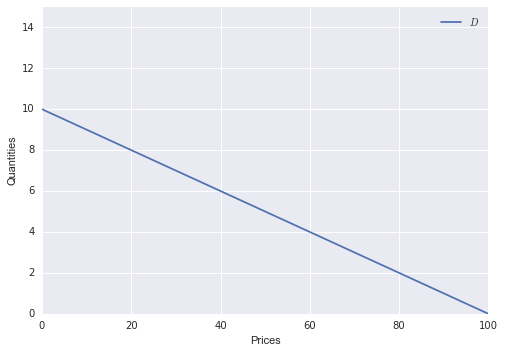

In [221]:
def quantity_demand_plot(beta_0=10.0, beta_1=-0.1):
    prices = np.linspace(0, 100, 1000)
    plt.plot(prices, quantity_demand(prices, beta_0, beta_1), label=r"$D$")
    plt.xlabel("Prices")
    plt.ylabel("Quantities")
    plt.ylim(0, 15)
    plt.legend()
    
ipywidgets.interact(quantity_demand_plot, beta_0=(0, 100, 1), beta_1=(-10, 0, 0.01))
plt.show()

<h2> Non-linear supply functions </h2>

$$ S_{\gamma}(p_t^e) $$

In [65]:
def quantity_supply(expected_price, gamma, p_bar, **params):
    return -np.arctan(-gamma * p_bar) + np.arctan(gamma * (expected_price - p_bar))

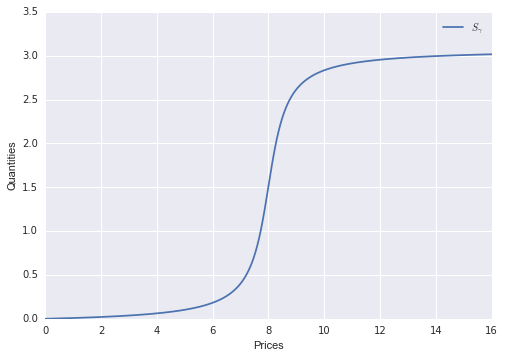

In [69]:
def quantity_supply_plot(gamma=50.0, p_bar=5.0):
    prices = np.linspace(0, 2 * p_bar, 1000)
    plt.plot(prices, quantity_supply(prices, gamma, p_bar), label=r"$S_{\gamma}$")
    plt.xlabel("Prices")
    plt.ylabel("Quantities")
    plt.legend()
    
ipywidgets.interact(quantity_supply_plot, gamma=(0, 100, 1), p_bar=(0, 100, 1))
plt.show()

<h2> Supply and demand </h2>

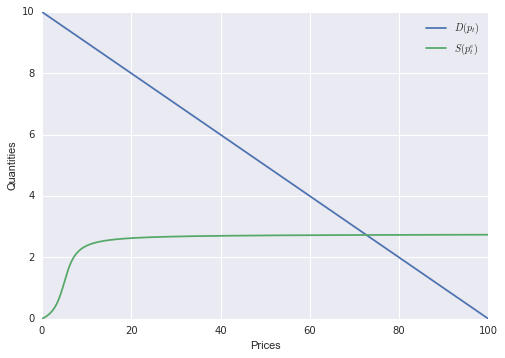

In [217]:
prices = np.linspace(0, 100, 1000)
plt.plot(prices, quantity_demand(prices, 10.0, -0.1), label=r"$D(p_t)$")
plt.plot(prices, quantity_supply(prices, 0.5, 5.0), label=r"$S(p_t^e)$")
plt.xlabel("Prices")
plt.ylabel("Quantities")

plt.legend()
plt.show()

<h2> Analyzing dynamics of the model via simulation... </h2>

In [138]:
def simulate(initial_condition, F, T, **params):
    X = np.empty(T + 1)
    X[0] = initial_condition
    for t in range(T):
        X[t+1] = F(X[t], **params)
    return X

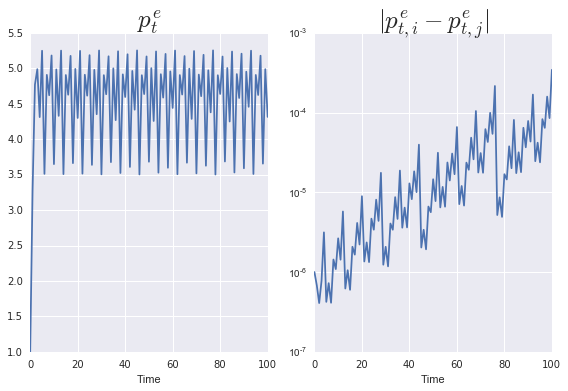

In [208]:
def time_series_plot(initial_condition=1.0, T=100, alpha=0.3, beta_0=0.01, beta_1=-0.25, gamma=3.6, p_bar=5.0):
    params = {'alpha': alpha, 'beta_0': beta_0, 'beta_1': beta_1, 'gamma': gamma, 'p_bar': p_bar}
    times = np.arange(0, T + 1, 1)
    f = functools.partial(adaptive_forecast_rule, inverse_demand, quantity_supply)
    traj1 = simulate(initial_condition, f, T, **params)
    traj2 = simulate(initial_condition + 1e-6, f, T, **params)
    
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(times, traj1)
    ax[0].set_title('$p_t^e$', fontsize=25)
    ax[0].set_xlabel('Time')
    
    ax[1].plot(times, np.abs(traj1 - traj2))
    ax[1].set_xlabel('Time')
    ax[1].set_yscale('log')
    ax[1].set_title('$|p_{t,i}^e - p_{t,j}^e|$', fontsize=25)
    fig.tight_layout()
    
    
ipywidgets.interact(time_series_plot,
                    initial_condition=(0, 10, 0.01),
                    alpha=(0, 1, 0.01),
                    beta_0=(0, 100, 0.01),
                    beta_1=(-10, 0, 0.01),
                    gamma=(0, 100, 0.01),
                    p_bar=(0, 100, 0.01))
plt.show()

<h2> Forecast errors </h2>

How do we measure forecast error?  What does the distribution of forecast errors look like for different parameters? Could an agent learn to avoid chaos? Specifically, suppose an agent learned to tune the value of $\alpha$ in order to minimize its mean forecast error. Would this eliminate chaotic dynamics?

In [157]:
def forecast_error(inverse_demand, supply, expected_price, **params):
    """Difference between observed price and expected price."""
    return observed_price(inverse_demand, supply, expected_price, **params) - expected_price

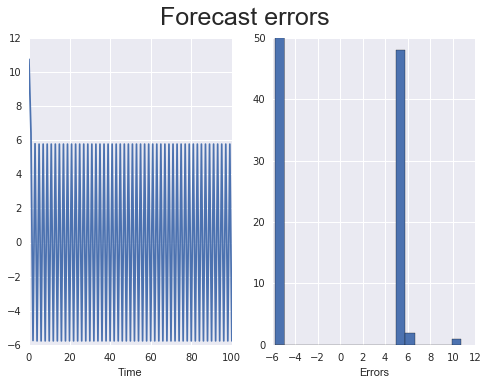

In [213]:
def forecast_error_plot(initial_condition=1.0, T=100, alpha=0.3, beta_0=0.01, beta_1=-0.25, gamma=3.6, p_bar=5.0):
    params = {'alpha': alpha, 'beta_0': beta_0, 'beta_1': beta_1, 'gamma': gamma, 'p_bar': p_bar}
    times = np.arange(0, T + 1, 1)
    f = functools.partial(adaptive_forecast_rule, inverse_demand, quantity_supply)
    expected_prices = simulate(initial_condition, f, T, **params)
    errors = forecast_error(inverse_demand, quantity_supply, expected_prices, **params)
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(errors)
    ax[0].set_xlabel('Time')
    
    ax[1].hist(errors, bins=20)
    fig.suptitle('Forecast errors', fontsize=25)
    ax[1].set_xlabel('Errors')
    
    
ipywidgets.interact(forecast_error_plot,
                    initial_condition=(0, 10, 0.01),
                    alpha=(0, 1, 0.01),
                    beta_0=(0, 100, 0.01),
                    beta_1=(-10, 0, 0.01),
                    gamma=(0, 100, 0.01),
                    p_bar=(0, 100, 0.01))
plt.show()